# Diffusion model for clutter denoising

## Initialization

### Imports

In [2]:
import os
import math
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch import einsum
from models.unet import *
import torch.optim as optim
from utils.trainer import *
#from models.newdif import *
from torch.optim import Adam
from utils.plotters import *
from utils.inference import *
from models.diffusion import *
from dataset.radardata import *
import torch.nn.functional as F
import matplotlib.pyplot as plt
from types import SimpleNamespace
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

### Define device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialiaze W&B + config

In [ ]:
run_name = 'range_doppler_trial'

In [5]:
wandb.init(
    project="New-Radar-diffusion",
    name=run_name,
    notes="Regular diffusion. this experiment is our benchmark - we check if changes are performing better or worse",
    config={
        "SNR": 10,
        "CNR": 15,
        "beta_end": 0.02,
        "beta_start": 1e-4,
        "batch_size": 16,
        "num_epochs": 400,
        "noise_steps": 2000,
        "num_workers": 4,
        "dataset_size": 50000,
        "time_emb_dim": 256,
        "learning_rate": 1e-4,        
        "scheduler_type": "linear",
    },
)
config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ari-granevich to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


## dataset prep

In [6]:
train_loader, val_loader, norm_train_loader, norm_val_loader, train_dataset_with_targets, norm_train_dataset, norm_val_dataset = prep_dataset(config)

Normalizing dataset: 100%|██████████| 5500/5500 [00:09<00:00, 596.23it/s]


## Dataset Visualization

In [7]:
# visualize_sample(train_dataset_with_targets, sample_index=1, plot_here=False, save_to_wandb=True) # regular dataset.
# visualize_sample(norm_train_dataset, sample_index=1, plot_here=False, save_to_wandb=True) # same dataset, after normalization.
# compare_nu_scnr(nu_values=[0.01, 0.1, 1], scnr_values=[-20, -10, 0, 10, 20], radar_dataset_class=RadarDataset, plot_here=False, save_to_wandb=True)

## train

In [8]:
train_loader = norm_train_loader
val_loader = norm_val_loader
cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=config.time_emb_dim).to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, scheduler_type=config.scheduler_type, T=config.noise_steps, 
    beta_start=config.beta_start, beta_end=config.beta_end).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), config.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4, cooldown=15, min_lr=1e-6, verbose=True)
num_epochs = config.num_epochs

/home/hawk/Desktop/Heavy-Clutter-Detection/finalDiffusion/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
best_val_loss = float('inf')
best_mse_loss = float('inf')
train_losses, val_losses, val_psnrs, val_mses = [], [], [], []
e_mse_loss = None
e_rd_loss = None
iq_val_loss = None
rd_val_loss = None

for epoch in range(num_epochs):
    #train_loss, e_mse_loss, e_rd_loss= train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    #val_loss, iq_val_loss, rd_val_loss, gen_mse, gen_psnr, rd_mse = validate(cond_diffusion, val_loader, device)

    train_loss= train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")

    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")

    scheduler.step(val_loss)

    if gen_mse < best_mse_loss:
        best_mse_loss = gen_mse
        torch.save(cond_diffusion.state_dict(), f"{run_name}.pth")
        print("   --> Best MSE model saved.")

    wandb.log({
        "total train loss": train_loss,
        "train mse loss": e_mse_loss if e_mse_loss is not None else float('nan'),
        "train rd loss": e_rd_loss if e_rd_loss is not None else float('nan'),
        "total val loss": val_loss,
        "IQ val loss": iq_val_loss if iq_val_loss is not None else float('nan'), 
        "RD val loss": rd_val_loss if rd_val_loss is not None else float('nan'),
        #"MSE between denoised RD and clean RD": rd_mse,
        "MSE between denoised IQ and clean IQ": gen_mse if gen_mse is not None else float('nan'),
        "generated IQ map PSNR": gen_psnr,
        "learning rate": optimizer.param_groups[0]['lr']  # Optional, log current LR
    })


Epoch 1/400: Train Loss = 0.3692 | Val Loss = 0.1750
   [Generation Metrics] MSE: 794927.0000 | PSNR: 11.60 dB
   --> Best MSE model saved.
Epoch 2/400: Train Loss = 0.1548 | Val Loss = 0.1358
   [Generation Metrics] MSE: 213374.0000 | PSNR: 17.31 dB
   --> Best MSE model saved.
Epoch 3/400: Train Loss = 0.1248 | Val Loss = 0.1222
   [Generation Metrics] MSE: 48426.7773 | PSNR: 23.75 dB
   --> Best MSE model saved.
Epoch 4/400: Train Loss = 0.1096 | Val Loss = 0.1043
   [Generation Metrics] MSE: 190416.2344 | PSNR: 17.80 dB
Epoch 5/400: Train Loss = 0.1003 | Val Loss = 0.1012
   [Generation Metrics] MSE: 852664.1250 | PSNR: 11.29 dB
Epoch 6/400: Train Loss = 0.0944 | Val Loss = 0.0892
   [Generation Metrics] MSE: 146000.8594 | PSNR: 18.96 dB
Epoch 7/400: Train Loss = 0.0883 | Val Loss = 0.0839
   [Generation Metrics] MSE: 210252.2500 | PSNR: 17.37 dB
Epoch 8/400: Train Loss = 0.0841 | Val Loss = 0.0856
   [Generation Metrics] MSE: 474481.6875 | PSNR: 13.84 dB
Epoch 9/400: Train Loss = 

KeyboardInterrupt: 

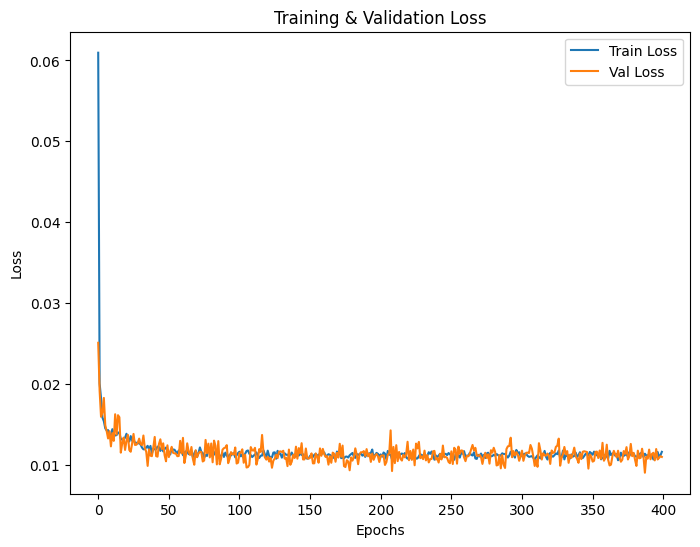

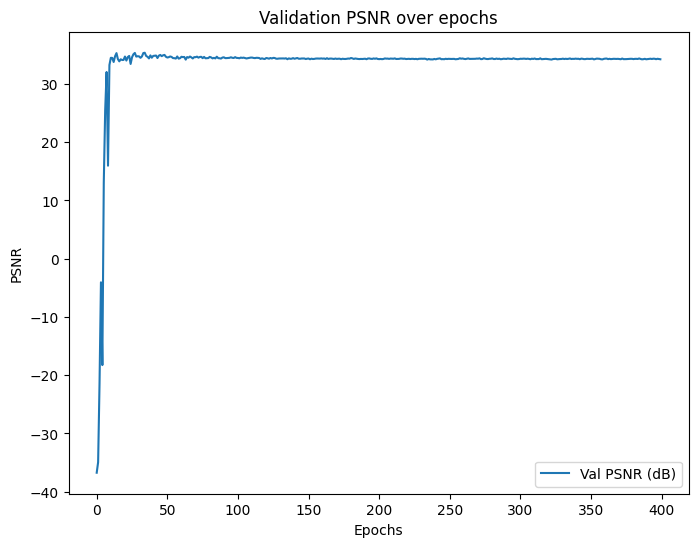

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

if len(val_psnrs) > 0:
    plt.figure(figsize=(8,6))
    plt.plot(val_psnrs, label="Val PSNR (dB)")
    plt.xlabel("Epochs")
    plt.ylabel("PSNR")
    plt.title("Validation PSNR over epochs")
    plt.legend()
    plt.show()

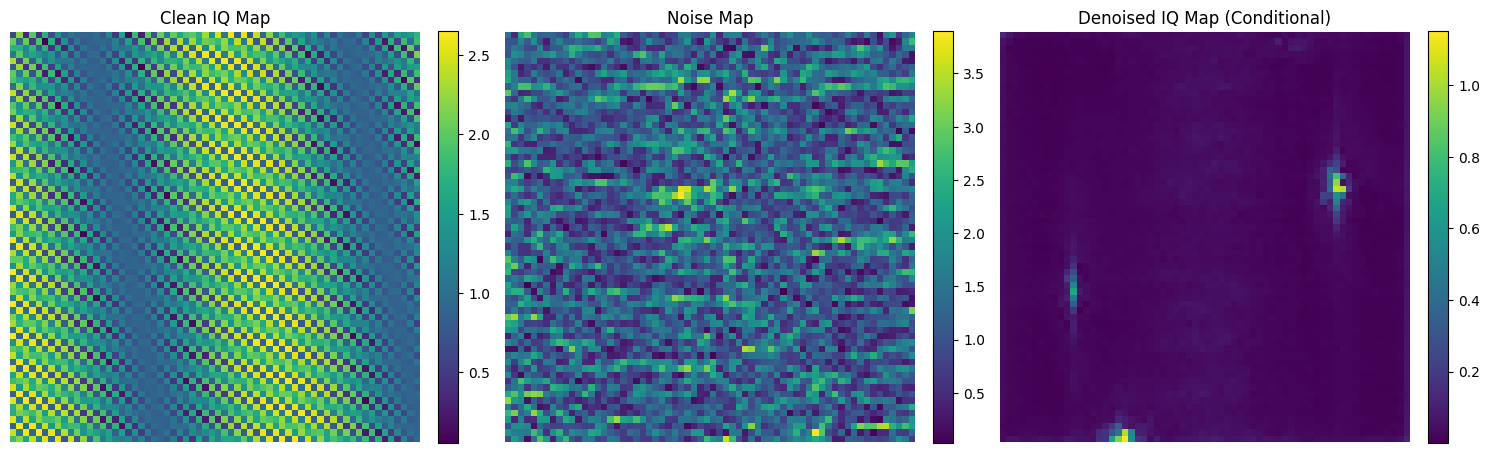

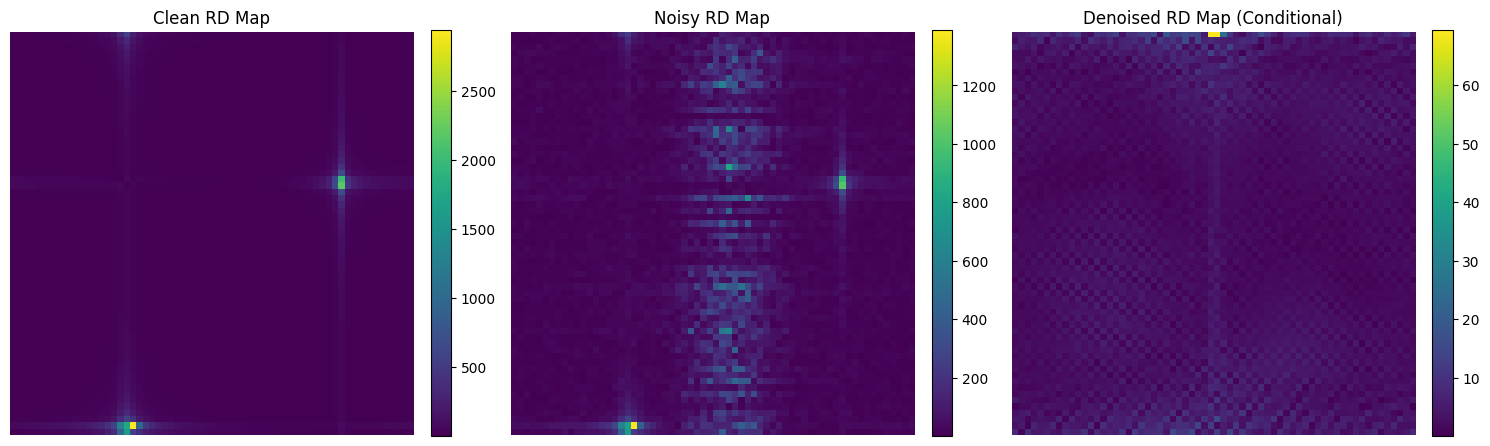

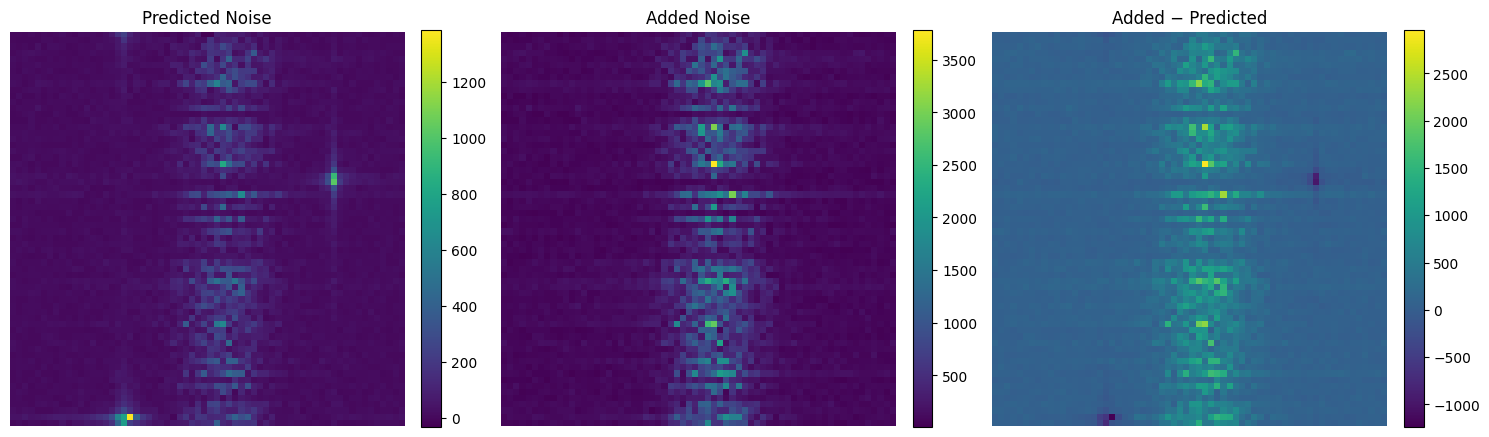

In [9]:
checkpoint_path = "/home/hawk/Desktop/Heavy-Clutter-Detection/finalDiffusion/range_doppler_trial.pth"
run_inference(cond_diffusion , norm_val_dataset, checkpoint_path, device)